# Introduction
- The goal of this section is to train a convolutional neural network on custom images (radiographss) from scratch. To achieve this, there are few operations we need to perform, which includes:
  - Connecting google colab to our google drive
  - Data Preparation: creating training and test data from the raw data
  - Building the CNN architecture
  - Training the network with and without transfer learning using pretrained models such as Vgg16, ResNet50, DenseNet121, MobileNetV1 and EfficientNet


- Dataset:https://stanfordmlgroup.github.io/competitions/mura/

In [ ]:
# Connect Google Colab to Google Drive
# from google.colab import drive
# drive.mount("/content/drive")

In [1]:
# install opencv-python
!pip install opencv-python


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# install keras-tuner

!pip install keras-tuner


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# mediumdataset 128 multiclass train-test split

In [3]:
# import the required libraries
import cv2
import numpy as np
import os
import shutil
import random

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from tensorflow import keras
import keras_tuner as kt

from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

In [4]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()

#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(142)
tf.random.set_seed(42)

# mediumdata 128 multiclass gridsearch VGG16

Found 1372 images belonging to 7 classes.
Found 588 images belonging to 7 classes.
Found 840 images belonging to 7 classes.
Epoch 1/10
43/43 [==============================] - 3708s 86s/step - loss: 1.7096 - accuracy: 0.4337 - val_loss: 1.0649 - val_accuracy: 0.6531
Epoch 2/10
43/43 [==============================] - 4019s 94s/step - loss: 0.9043 - accuracy: 0.6866 - val_loss: 0.8656 - val_accuracy: 0.7449
Epoch 3/10
43/43 [==============================] - 6014s 141s/step - loss: 0.7463 - accuracy: 0.7500 - val_loss: 0.7325 - val_accuracy: 0.7789
Epoch 4/10
43/43 [==============================] - 6028s 141s/step - loss: 0.6125 - accuracy: 0.7923 - val_loss: 0.6860 - val_accuracy: 0.7619
Epoch 5/10
43/43 [==============================] - 4957s 116s/step - loss: 0.5047 - accuracy: 0.8331 - val_loss: 0.6673 - val_accuracy: 0.7381
Epoch 6/10
43/43 [==============================] - 4692s 110s/step - loss: 0.4410 - accuracy: 0.8571 - val_loss: 0.6149 - val_accuracy: 0.8027
Epoch 7/10
43/

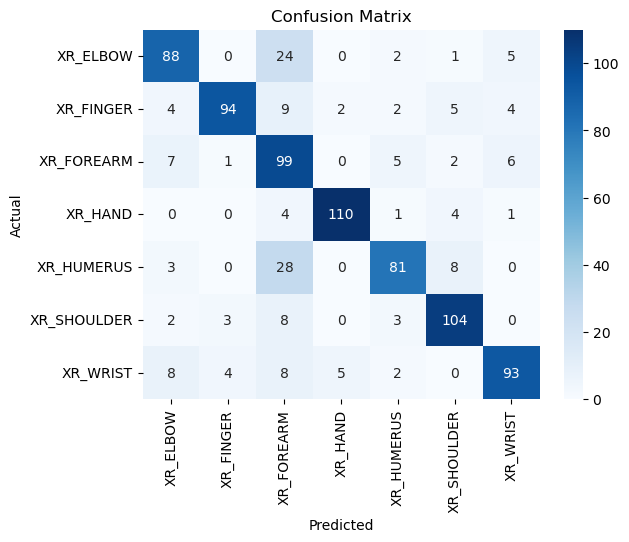

Sensitivity: [0.73333333 0.78333333 0.825      0.91666667 0.675      0.86666667
 0.775     ]
Specificity: [0.78571429 0.92156863 0.55       0.94017094 0.84375    0.83870968
 0.85321101]


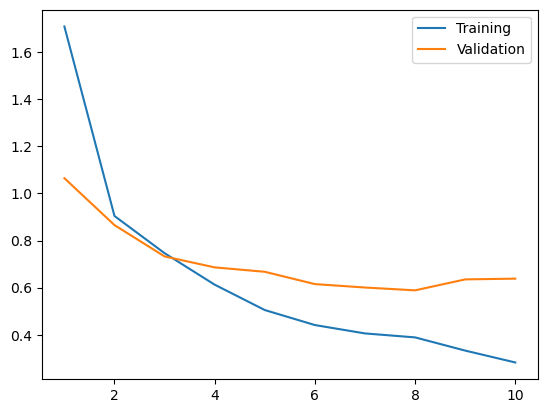

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Define paths
train_dir = "C:/Users/OLASUNKANMI/Desktop/UoL DS Course files/Semester C/UoL Research Project Materials/New_Mura/medium_dataset/128/Multiclass/train"
test_dir = "C:/Users/OLASUNKANMI/Desktop/UoL DS Course files/Semester C/UoL Research Project Materials/New_Mura/medium_dataset/128/Multiclass/test"


# Data Preprocessing
image_size = (128, 128)
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

# Load VGG16 Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze base model

# Add Custom Layers
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
out = Dense(7, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=out)

# Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model
history = model.fit(train_generator, validation_data=val_generator, epochs=10)

# Evaluate on Test Data
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate Sensitivity and Specificity
sensitivity = cm.diagonal() / cm.sum(axis=1)
specificity = cm.diagonal() / cm.sum(axis=0)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

# Visualize the loss
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, label="Training")
plt.plot(epochs, val_loss, label="Validation")
plt.legend(loc="best")
plt.show()

In [6]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()

#Fixing the seed for random number generators
np.random.seed(1042)
import random
random.seed(1042)
tf.random.set_seed(1042)

# mediumdata 128 multiclass 5fold CV vgg16

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
from sklearn.model_selection import KFold

# Define paths
train_dir = "C:/Users/OLASUNKANMI/Desktop/UoL DS Course files/Semester C/UoL Research Project Materials/New_Mura/medium_dataset/128/Multiclass/train"
test_dir = "C:/Users/OLASUNKANMI/Desktop/UoL DS Course files/Semester C/UoL Research Project Materials/New_Mura/medium_dataset/128/Multiclass/test"

# Data Preprocessing
image_size = (128, 128)
batch_size = 32
cv_folds = 5

# Image Data Generators
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

def create_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    base_model.trainable = False  # Freeze base model
    
    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(7, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Perform Cross-Validation
kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

for fold, (train_index, val_index) in enumerate(kf.split(train_generator.filenames)):
    print(f"Training fold {fold+1}/{cv_folds}")
    
    train_generator = datagen.flow_from_directory(
        train_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training')
    
    val_generator = datagen.flow_from_directory(
        train_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation')
    
    model = create_model()
    history = model.fit(train_generator, validation_data=val_generator, epochs=10)

# Evaluate on Test Data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Sensitivity and Specificity
sensitivity = cm.diagonal() / cm.sum(axis=1)
specificity = cm.diagonal() / cm.sum(axis=0)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

# Loss Visualization
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

Training fold 1/5
Found 1372 images belonging to 7 classes.
Found 588 images belonging to 7 classes.
Epoch 1/10
43/43 [==============================] - 3315s 77s/step - loss: 1.7099 - accuracy: 0.4082 - val_loss: 1.1406 - val_accuracy: 0.5799
Epoch 2/10
43/43 [==============================] - 3282s 77s/step - loss: 0.9683 - accuracy: 0.6633 - val_loss: 0.8641 - val_accuracy: 0.7092
Epoch 3/10
43/43 [==============================] - 3312s 78s/step - loss: 0.7844 - accuracy: 0.7208 - val_loss: 0.7991 - val_accuracy: 0.7075
Epoch 4/10
43/43 [==============================] - 3222s 75s/step - loss: 0.6415 - accuracy: 0.7813 - val_loss: 0.7284 - val_accuracy: 0.7449
Epoch 5/10
43/43 [==============================] - 3141s 74s/step - loss: 0.5489 - accuracy: 0.8163 - val_loss: 0.6700 - val_accuracy: 0.7653
Epoch 6/10
43/43 [==============================] - 3142s 74s/step - loss: 0.5159 - accuracy: 0.8294 - val_loss: 0.6265 - val_accuracy: 0.8095
Epoch 7/10
43/43 [=======================

In [10]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()

#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(142)
tf.random.set_seed(42)

# mediumdata 128 multiclass 10-Fold CV

Training fold 1/10
Found 1372 images belonging to 7 classes.
Found 588 images belonging to 7 classes.
Epoch 1/10
43/43 [==============================] - 777s 18s/step - loss: 1.6686 - accuracy: 0.3739 - val_loss: 1.1903 - val_accuracy: 0.6037
Epoch 2/10
43/43 [==============================] - 690s 16s/step - loss: 1.1492 - accuracy: 0.6013 - val_loss: 1.0970 - val_accuracy: 0.6361
Epoch 3/10
43/43 [==============================] - 695s 16s/step - loss: 0.9456 - accuracy: 0.6655 - val_loss: 0.9864 - val_accuracy: 0.6361
Epoch 4/10
43/43 [==============================] - 667s 16s/step - loss: 0.8490 - accuracy: 0.6990 - val_loss: 0.9016 - val_accuracy: 0.6922
Epoch 5/10
43/43 [==============================] - 705s 17s/step - loss: 0.7469 - accuracy: 0.7434 - val_loss: 0.8573 - val_accuracy: 0.6888
Epoch 6/10
43/43 [==============================] - 657s 15s/step - loss: 0.6853 - accuracy: 0.7675 - val_loss: 0.8271 - val_accuracy: 0.7109
Epoch 7/10
43/43 [============================

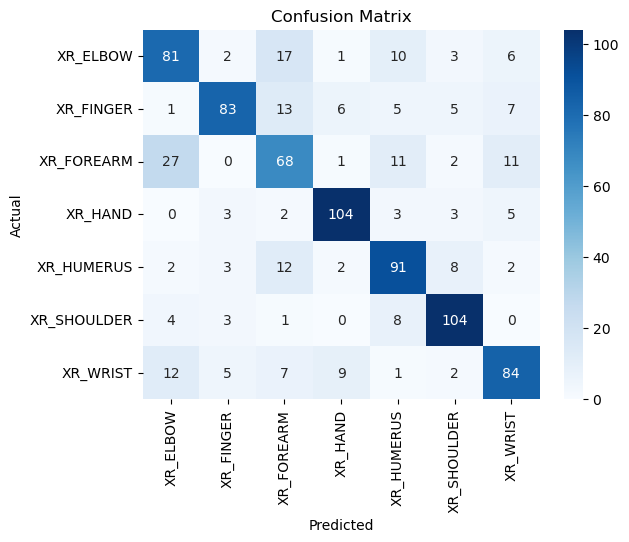

Sensitivity: [0.675      0.69166667 0.56666667 0.86666667 0.75833333 0.86666667
 0.7       ]
Specificity: [0.63779528 0.83838384 0.56666667 0.84552846 0.70542636 0.81889764
 0.73043478]


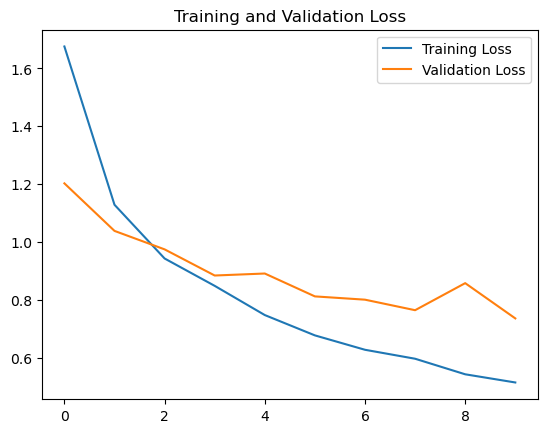

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
from sklearn.model_selection import KFold

# Define paths
train_dir = "C:/Users/OLASUNKANMI/Desktop/UoL DS Course files/Semester C/UoL Research Project Materials/New_Mura/medium_dataset/128/Multiclass/train"
test_dir = "C:/Users/OLASUNKANMI/Desktop/UoL DS Course files/Semester C/UoL Research Project Materials/New_Mura/medium_dataset/128/Multiclass/test"

# Data Preprocessing
image_size = (128, 128)
batch_size = 32
cv_folds = 10

# Image Data Generators
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

def create_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    base_model.trainable = False  # Freeze base model
    
    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(7, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Perform Cross-Validation
kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

for fold, (train_index, val_index) in enumerate(kf.split(train_generator.filenames)):
    print(f"Training fold {fold+1}/{cv_folds}")
    
    train_generator = datagen.flow_from_directory(
        train_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training')
    
    val_generator = datagen.flow_from_directory(
        train_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation')
    
    model = create_model()
    history = model.fit(train_generator, validation_data=val_generator, epochs=10)

# Evaluate on Test Data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Sensitivity and Specificity
sensitivity = cm.diagonal() / cm.sum(axis=1)
specificity = cm.diagonal() / cm.sum(axis=0)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

# Loss Visualization
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()